# Preparations
Let's get a dataset, split it to train and test and create a ML model fitted on the train set

In [1]:
import numpy
import pandas
import sklearn
import sklearn.datasets
from matplotlib import pyplot as plt
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
# get dataset
x, y = sklearn.datasets.load_digits(return_X_y=True)
feature_names = ['feature #%d' % k for k in range(x.shape[1])]
print("Loaded dataset of size {}".format(x.shape))


Loaded dataset of size (1797, 64)


In [3]:
# let's add some missing values to dataset

rs = numpy.random.RandomState(0)
nan_locs = numpy.ones(numpy.prod(x.shape))
nan_locs[rs.permutation(len(nan_locs))[:int(len(nan_locs)*0.05)]] = numpy.nan
nan_locs = nan_locs.reshape(x.shape)
x = x * nan_locs
print("Added 5% missing values to dataset")

Added 5% missing values to dataset


In [4]:
# create train/test sets
itrain, itest = sklearn.model_selection.train_test_split(numpy.arange(len(y)), test_size=0.25)
xtrain, xtest = x[itrain,:], x[itest,:]
ytrain, ytest = y[itrain], y[itest]
print("split to train/test")

split to train/test


In [5]:
# train RandomForest with imputation preprocess
# imputation preprocess is required for sensitivity to missing values

estimators = []
estimators.append(('Imputer', SimpleImputer()))
estimators.append(('Estimator', RandomForestClassifier(n_estimators=10, random_state=0)))
estimator = Pipeline(steps=estimators)
    
estimator.fit(xtrain, ytrain)
print("Finished training {}".format(type(estimator.steps[-1][1]).__name__))

Finished training RandomForestClassifier



##  ---- Finished preparation  ----




# Init Pytrust object
Pytrust class requires the following information for the analysis:
- Train Set
- Test Set
- sample meta data (e.g. sample weights) for each sample in Train/Test sets
- columns meta data (e.g, feature names) for each column in dataset.
- Model trained on Train Set
- Metric used to measure model performance
- Splitter - how data should be split. 

In [6]:
from pytolemaic.pytrust import PyTrust

from pytolemaic.utils.dmd import DMD
from pytolemaic.utils.general import GeneralUtils
from pytolemaic.utils.metrics import Metrics


In [7]:
# some definitions 

metric_of_interest = Metrics.recall.name

## set splitting strategy
splitter = 'shuffled'

In [8]:
## sample meta data (e.g. sample weight) - empty in this example
sample_meta_train = None
sample_meta_test = None

# set the feature names names
columns_meta = {DMD.FEATURE_NAMES: feature_names}

pytrust = PyTrust(
    model=estimator,
    xtrain=xtrain, ytrain=ytrain,
    xtest=xtest, ytest=ytest,
    sample_meta_train=sample_meta_train, sample_meta_test=sample_meta_test,
    columns_meta=columns_meta,
    metric=metric_of_interest,
    splitter=splitter)

print("Pytrust object initiated")

Pytrust object initiated


# Sensitivity Analysis Example

{'MISSING': {'META': {'N_FEATURES': 64,
                      'N_LOW': 17,
                      'N_NON_ZERO': 50,
                      'N_ZERO': 14},
             'SENSITIVITY': {'feature #0': 0.0,
                             'feature #1': 0.00455,
                             'feature #10': 0.01421,
                             'feature #11': 0.00782,
                             'feature #12': 0.01871,
                             'feature #13': 0.02623,
                             'feature #14': 0.00853,
                             'feature #15': 0.0,
                             'feature #16': 0.0,
                             'feature #17': 0.01375,
                             'feature #18': 0.03145,
                             'feature #19': 0.02262,
                             'feature #2': 0.03012,
                             'feature #20': 0.01199,
                             'feature #21': 0.04079,
                             'feature #22': 0.01091,
               

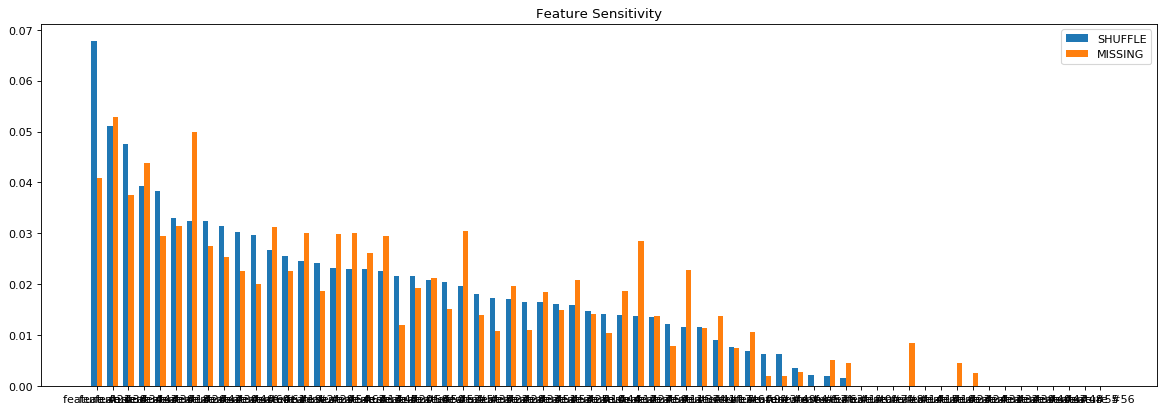

In [9]:
sensitivity_report = pytrust.sensitivity_report().simplified_keys()
pprint(sensitivity_report)
    
shuffled = sensitivity_report['SHUFFLE']['SENSITIVITY']
missing = sensitivity_report['MISSING']['SENSITIVITY']
sorted_features = list(sorted(shuffled.keys(), key=lambda k: shuffled[k], reverse=True))
y_shuffle = [shuffled[feature] for feature in sorted_features]
y_missing = [missing[feature] for feature in sorted_features]

fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
w = 0.8
xloc = numpy.arange(len(sorted_features))*3*w
plt.bar(xloc-w/2, y_shuffle, w, label='SHUFFLE')
plt.bar(xloc+w/2, y_missing, w, label='MISSING')
plt.xticks(xloc, sorted_features)
plt.legend()
plt.title('Feature Sensitivity')
plt.draw()


# Scoring example

{'QUALITY': 0.9933,
 'recall': {'CI_HIGH': 0.92706, 'CI_LOW': 0.90972, 'SCORE_VALUE': 0.92336}}


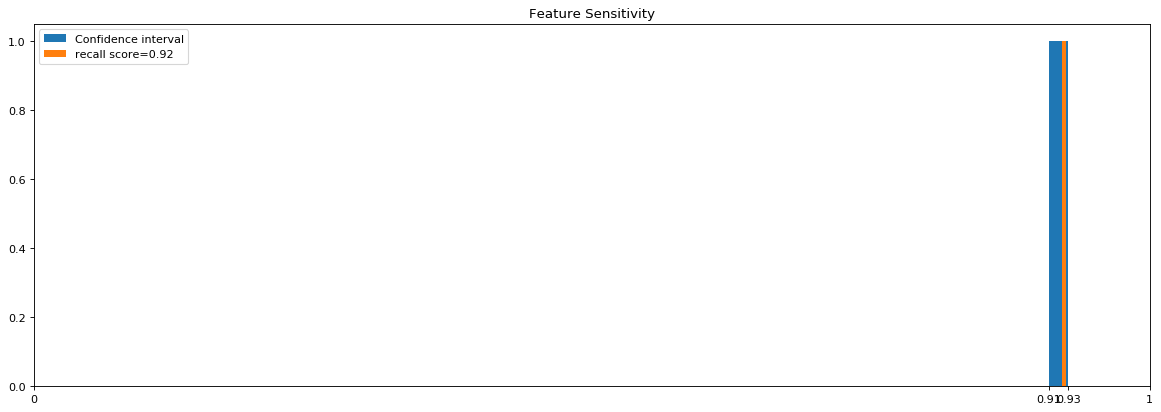

In [10]:
score_report = pytrust.scoring_report().simplified_keys()
pprint(score_report)


ci_low = score_report[metric_of_interest]['CI_LOW']
score = score_report[metric_of_interest]['SCORE_VALUE']
ci_high = score_report[metric_of_interest]['CI_HIGH']

fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

xloc = numpy.arange(len(sorted_features))*3*w
plt.bar((ci_high+ci_low)/2, 1, ci_high-ci_low)
plt.bar(score, 1, min((ci_high-ci_low)/5, 0.01))
plt.xticks([0, ci_low, ci_high, 1], ['0',"{:.2f}".format(ci_low), "{:.2f}".format(ci_high),'1'])
plt.legend(['Confidence interval', '{} score={:.2f}'.format(metric_of_interest, score)])
plt.title('Feature Sensitivity')
plt.draw()


# Quality report

{'test_set': {'overall_quality': 0.93971,
              'quality_components': {'ci_ratio': 0.98122,
                                     'separation_quality': 0.95849}},
 'train_set': {'overall_quality': 0.2974,
               'quality_components': {'imputation': 0.7974,
                                      'leakage': 1.0,
                                      'overfit': 0.5}}}


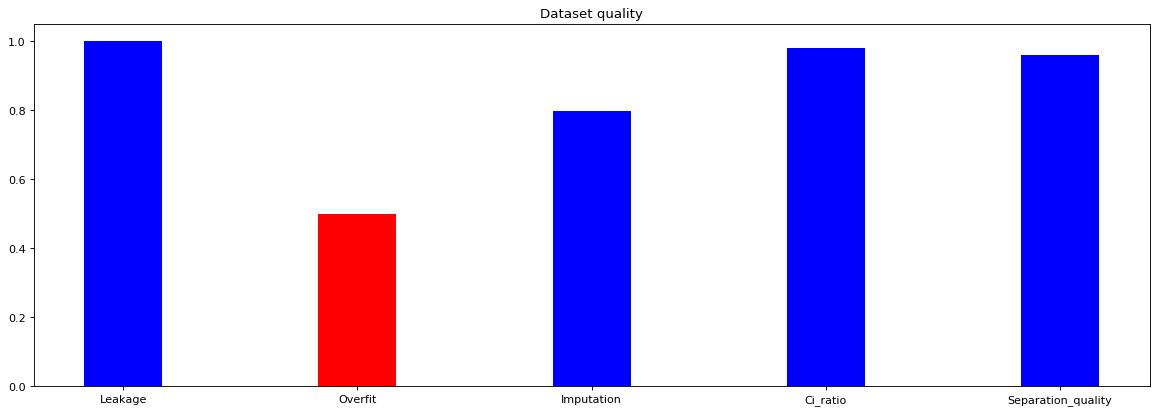

In [11]:
quality_report = pytrust.quality_report().simplified_keys()

pprint(quality_report)


quality_components = {}

quality_components.update(quality_report['train_set']['quality_components'])
quality_components.update(quality_report['test_set']['quality_components'])

components, quality = zip(*quality_components.items())
components = [c.capitalize() for c in components]

fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
w = 0.8
xloc = numpy.arange(len(components))*3*w
plt.bar(xloc, quality, w, color=['b' if q>0.5 else 'r' for q in quality])
plt.xticks(xloc, components)
plt.title('Dataset quality')
plt.draw()